In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import brier_score_loss, mean_squared_error

# Outline

## Aim

The aim is to be able to predict the matchup any team in the NCAA, separating mens and womens leagues.

## Submission
It must have two columns: Matchup anmd prediction. Matchup format "YYYY_TEAM1_TEAM2" while prediction, sets to 1 if TEAM1 is predicted to beat TEAM2.

## Perfomance tracking

A weighted function will calculate the performance of a team across a season. If team is seeded into the tournament, then the performance score increases.
Everytime a team wins in the tournament the performance increases accordingly. This weighted function will each performance of teams acrross since 2003.

Ideally, also track how a team performs against another depending on the other teams performance. Then do a regression analysis on how the performance affects the outcome of the match. So that it ouputs this probability.

# Season Performance per team

The idea is to track how a team performs throughout the season. Setting a score for performance. Performance will be calculated based on how the team has peformed throughout the season, capturing its momentum. 

In [2]:
# load the data
df_seasons = pd.read_csv('data/MRegularSeasonDetailedResults.csv')
df_seasons.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [3]:
df_seeds = pd.read_csv('data/MNCAATourneySeeds.csv')
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [4]:
# from season 2003 and up get a list of all teams that got season seeds and into a subdictionary of the conference which is the first letter of the seed
seeds_dict = df_seeds[df_seeds['Season'] >= 2003].groupby('Season') 
seeds_dict

In [123]:
# get all the teams
teams_df = pd.read_csv('data/MTeams.csv')
teams_df.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2025
1,1102,Air Force,1985,2025
2,1103,Akron,1985,2025
3,1104,Alabama,1985,2025
4,1105,Alabama A&M,2000,2025


### How many teams?

In [124]:
# get all unique team ids
team_ids = teams_df['TeamID'].unique()
team_ids

array([1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111,
       1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122,
       1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133,
       1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144,
       1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155,
       1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166,
       1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177,
       1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188,
       1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199,
       1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210,
       1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221,
       1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232,
       1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243,
       1244, 1245, 1246, 1247, 1248, 1249, 1250, 12

### Get performance per season

In [163]:
# lets do the first season as 2003
# lets get the performance of each team that got seeded by adding a point for each win
# and removing a point for each loss
# if its zero then do nothing
# Initialize a dictionary to track performance by day
performance_by_day = {team: [] for team in team_ids}

# Iterate through each game day
for day in range(1, df_seasons[df_seasons['Season'] == 2003]['DayNum'].max() + 1):
    # Filter games for the current day
    games_today = df_seasons[(df_seasons['Season'] == 2003) & (df_seasons['DayNum'] == day)]
    
    # Update performance for each game
    for _, game in games_today.iterrows():
        if game['WTeamID'] in performance_by_day:
            performance_by_day[game['WTeamID']].append(1)
        if game['LTeamID'] in performance_by_day:
            performance_by_day[game['LTeamID']].append(-1)

# Convert performance to cumulative sum
cumulative_performance = {team: np.cumsum(performance_by_day[team]) for team in performance_by_day}

# Convert to DataFrame for plotting
performance_df = pd.DataFrame.from_dict(cumulative_performance, orient='index').transpose()


In [136]:
# convert the above to a function that takes in a season and returns the performance of each team
def get_team_performance(df_seasons, season):
    # Initialize a dictionary to track performance by day
    performance_by_day = {team: [] for team in team_ids}

    # Iterate through each game day
    for day in range(1, df_seasons[df_seasons['Season'] == season]['DayNum'].max() + 1):
        # Filter games for the current day
        games_today = df_seasons[(df_seasons['Season'] == season) & (df_seasons['DayNum'] == day)]

        # Update performance for each game
        for _, game in games_today.iterrows():
            if game['WTeamID'] in performance_by_day:
                performance_by_day[game['WTeamID']].append(1)
            if game['LTeamID'] in performance_by_day:
                performance_by_day[game['LTeamID']].append(-1)

    # Convert performance to cumulative sum
    cumulative_performance = {team: np.cumsum(performance_by_day[team]) for team in performance_by_day}

    # Convert to DataFrame for plotting
    performance_df = pd.DataFrame.from_dict(cumulative_performance, orient='index').transpose()
    
    return performance_df

In [164]:
performance_df

,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,...,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480
0,NaN,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,NaN,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.0,0.0,2.0,-2.0,-2.0,-2.0,-2.0,NaN,-2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.0,-1.0,3.0,-3.0,-3.0,-3.0,-1.0,NaN,-3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.0,-2.0,4.0,-2.0,-4.0,-2.0,-2.0,NaN,-2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,-1.0,5.0,-1.0,-5.0,-3.0,-3.0,NaN,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,2.0,-2.0,6.0,-2.0,-4.0,-2.0,-4.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,3.0,-1.0,7.0,-3.0,-5.0,-3.0,-5.0,NaN,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,2.0,0.0,8.0,-2.0,-4.0,-4.0,-6.0,NaN,-2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,1.0,1.0,9.0,-3.0,-5.0,-5.0,-7.0,NaN,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,2.0,0.0,8.0,-4.0,-4.0,-4.0,-8.0,NaN,-2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


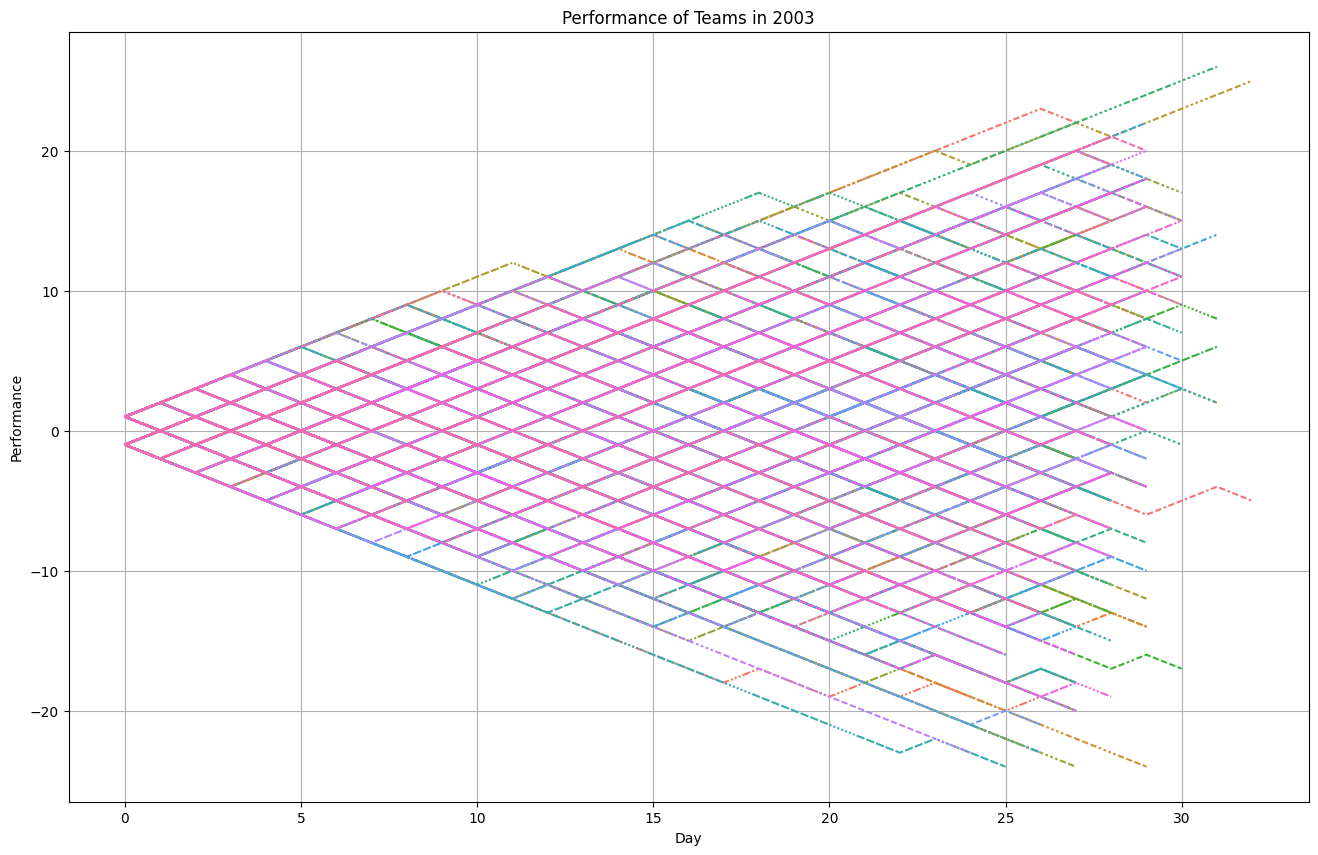

In [135]:
# lets plot the performance of the teams
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(16, 10))
plt.title('Performance of Teams in 2003')
plt.xlabel('Day')
plt.ylabel('Performance')
plt.grid(True)
# no legend
sns.lineplot(data=performance_df, legend=False)
plt.show()

### Performance statistics for the regular season

In [162]:
# convert the above to a function that takes in a conference and returns the results
def get_performance_results(performance_df):
    # Compute first derivative (slope) - rate of change in performance
    df_slope = performance_df.diff()

    # Compute second derivative (acceleration) - rate of change of the slope
    df_acceleration = df_slope.diff()

    # Compute volatility as the standard deviation of slopes (measure of performance consistency)
    volatility = performance_df.std()

    # Identify major turning points (where acceleration is significantly high)
    turning_points = (df_acceleration.abs() > df_acceleration.abs().mean()).sum()
    

    # Split the season into two halves for slope difference momentum
    midpoint = len(performance_df) // 2
    first_half_slope = performance_df.iloc[:midpoint].diff().mean()
    second_half_slope = performance_df.iloc[midpoint:].diff().mean()
    momentum_slope_difference = second_half_slope - first_half_slope

    # Compute Exponentially Weighted Momentum (giving more weight to recent games)
    weights = np.exp(np.linspace(0, 2, len(performance_df)))  # Exponential weights increasing over time
    weighted_momentum = (df_slope.mul(weights, axis=0)).sum() / weights.sum()

    # Combine all metrics into a dataframe
    results_df = pd.DataFrame({
        "Average Slope": df_slope.mean(),
        "Average Acceleration": df_acceleration.mean(),
        "Volatility (Std Dev)": volatility,
        "Turning Points": turning_points,
        "Momentum (Slope Difference)": momentum_slope_difference,
        "Weighted Momentum": weighted_momentum
    })
    
    return results_df


In [165]:
df_perfomance_score = get_performance_results(performance_df)
df_perfomance_score

,Average Slope,Average Acceleration,Volatility (Std Dev),Turning Points,Momentum (Slope Difference),Weighted Momentum
1101,NaN,NaN,NaN,0,NaN,0.000000
1102,-0.111111,-0.076923,2.409198,11,-0.836364,-0.207434
1103,0.000000,-0.080000,1.120897,11,0.066667,-0.004893
1104,0.185185,-0.076923,2.217057,13,-0.557576,0.000915
1105,-0.440000,0.000000,3.464324,12,0.133333,-0.283384
...,...,...,...,...,...,...
1476,NaN,NaN,NaN,0,NaN,0.000000
1477,NaN,NaN,NaN,0,NaN,0.000000
1478,NaN,NaN,NaN,0,NaN,0.000000
1479,NaN,NaN,NaN,0,NaN,0.000000


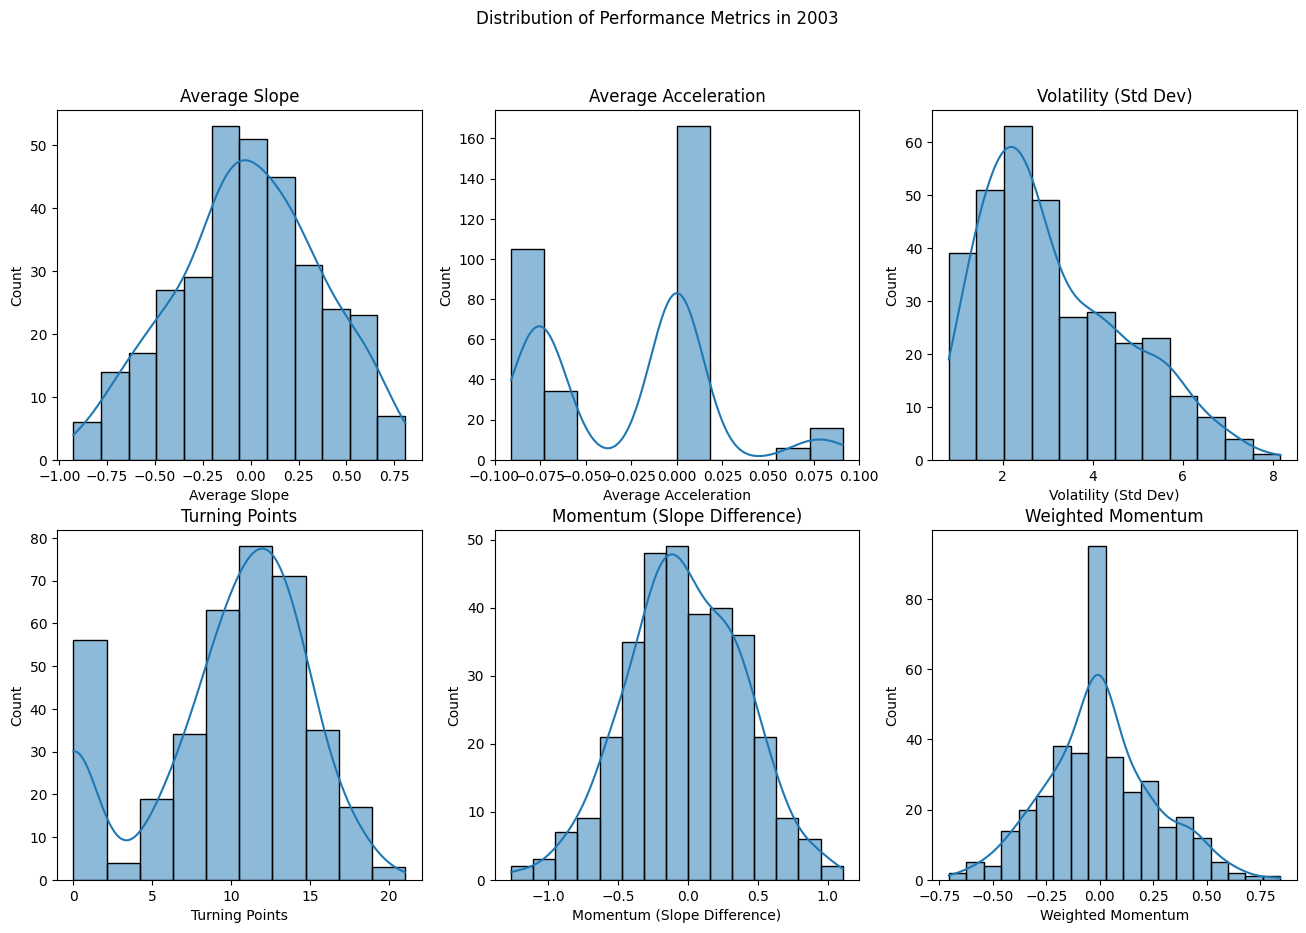

In [166]:
# plot the distriutions of the performance metrics one chart for each metric
# Set up the matplotlib figure
plt.figure(figsize=(16, 10))
plt.suptitle('Distribution of Performance Metrics in 2003')

# Plot Average Slope
plt.subplot(2, 3, 1)
plt.title('Average Slope')
sns.histplot(df_perfomance_score['Average Slope'], kde=True)

# Plot Average Acceleration
plt.subplot(2, 3, 2)
plt.title('Average Acceleration')
sns.histplot(df_perfomance_score['Average Acceleration'], kde=True)

# Plot Volatility
plt.subplot(2, 3, 3)
plt.title('Volatility (Std Dev)')
sns.histplot(df_perfomance_score['Volatility (Std Dev)'], kde=True)

# Plot Turning Points
plt.subplot(2, 3, 4)
plt.title('Turning Points')
sns.histplot(df_perfomance_score['Turning Points'], kde=True, bins=10)

# Plot Momentum (Slope Difference)
plt.subplot(2, 3, 5)
plt.title('Momentum (Slope Difference)')
sns.histplot(df_perfomance_score['Momentum (Slope Difference)'], kde=True)

# Plot Weighted Momentum
plt.subplot(2, 3, 6)
plt.title('Weighted Momentum')
sns.histplot(df_perfomance_score['Weighted Momentum'], kde=True)

plt.show()



### Performance Score for the regular season

In [167]:
def team_performance_score(df, w1=1, w2=1, w3=1, w4=1, w5=1, w6=1):
    """
    Computes a weighted performance score for each team.
    
    Parameters:
    df : DataFrame containing performance metrics for each team.
    w1, w2, w3, w4, w5, w6 : Weights for different metrics (default = 1).
    
    Returns:
    DataFrame with scores for each team.
    """
    # Compute inverse for volatility and turning points to give higher scores for more stable teams
    inv_volatility = 1 / (df["Volatility (Std Dev)"] + 1e-6)  # Add small value to avoid division by zero
    inv_turning_points = 1 / (df["Turning Points"] + 1e-6)

    # Compute the score
    df["Performance Score"] = (
        w1 * df["Average Slope"] +
        w2 * df["Average Acceleration"] +
        w3 * inv_volatility +
        w4 * inv_turning_points +
        w5 * df["Momentum (Slope Difference)"] +
        w6 * df["Weighted Momentum"]
    )

    return df

In [168]:
df_perfomance_score = team_performance_score(df_perfomance_score)
df_perfomance_score

,Average Slope,Average Acceleration,Volatility (Std Dev),Turning Points,Momentum (Slope Difference),Weighted Momentum,Performance Score
1101,NaN,NaN,NaN,0,NaN,0.000000,NaN
1102,-0.111111,-0.076923,2.409198,11,-0.836364,-0.207434,-0.725847
1103,0.000000,-0.080000,1.120897,11,0.066667,-0.004893,0.964825
1104,0.185185,-0.076923,2.217057,13,-0.557576,0.000915,0.079572
1105,-0.440000,0.000000,3.464324,12,0.133333,-0.283384,-0.218061
...,...,...,...,...,...,...,...
1476,NaN,NaN,NaN,0,NaN,0.000000,NaN
1477,NaN,NaN,NaN,0,NaN,0.000000,NaN
1478,NaN,NaN,NaN,0,NaN,0.000000,NaN
1479,NaN,NaN,NaN,0,NaN,0.000000,NaN


In [169]:
# sort by performance score
df_perfomance_score.sort_values('Performance Score', ascending=False, inplace=True)
df_perfomance_score

,Average Slope,Average Acceleration,Volatility (Std Dev),Turning Points,Momentum (Slope Difference),Weighted Momentum,Performance Score
1246,0.806452,0.066667,8.163402,5,0.400000,0.842884,2.438500
1335,0.615385,0.080000,5.809169,5,0.666667,0.500680,2.234873
1451,0.714286,0.000000,6.110437,6,0.533333,0.612963,2.190904
1221,0.785714,0.000000,6.637147,6,0.266667,0.632895,2.002610
1237,0.161290,0.066667,2.676059,13,0.933333,0.383595,1.995492
...,...,...,...,...,...,...,...
1476,NaN,NaN,NaN,0,NaN,0.000000,NaN
1477,NaN,NaN,NaN,0,NaN,0.000000,NaN
1478,NaN,NaN,NaN,0,NaN,0.000000,NaN
1479,NaN,NaN,NaN,0,NaN,0.000000,NaN


# Tournament scores

In [170]:
df_seeds_2003 = df_seeds[df_seeds['Season'] == 2003]
df_seeds_2003

,Season,Seed,TeamID
1154,2003,W01,1328
1155,2003,W02,1448
1156,2003,W03,1393
1157,2003,W04,1257
1158,2003,W05,1280
...,...,...,...
1214,2003,Z12,1454
1215,2003,Z13,1443
1216,2003,Z14,1161
1217,2003,Z15,1429


## Tracking performance of regular season of seeded teams

In [172]:
# how many conferences
conferences = df_seeds_2003['Seed'].str[0].unique()
print(conferences)

['W' 'X' 'Y' 'Z']


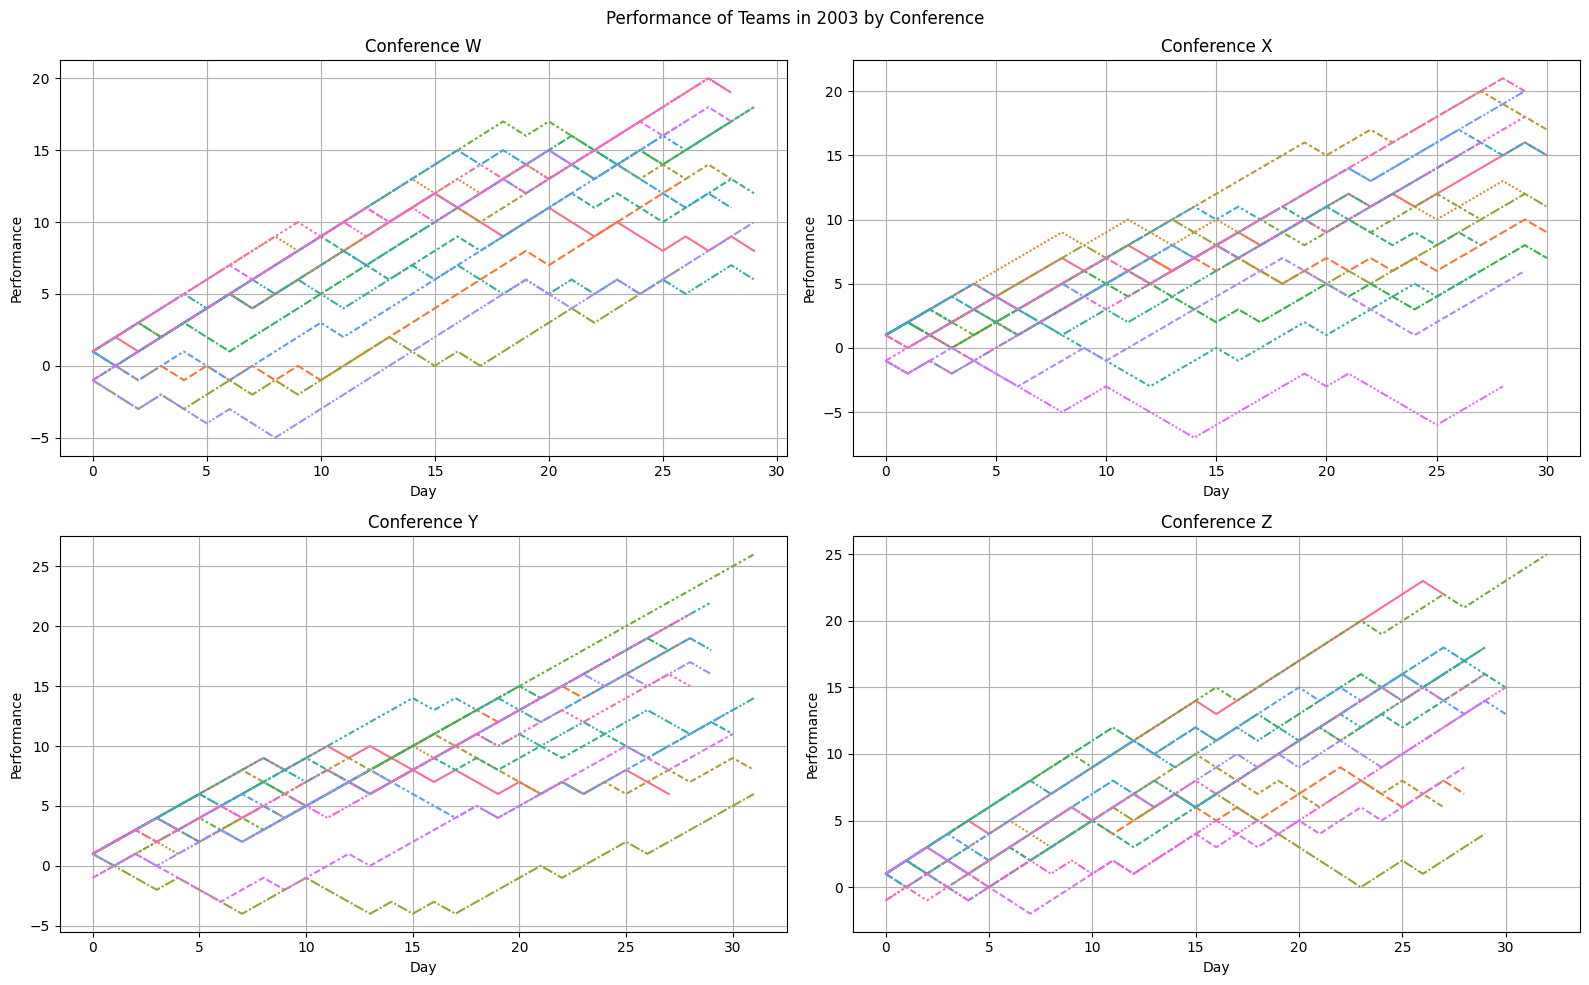

In [174]:
# for each conference plot the performance of each team seeded
# Set up the matplotlib figure
plt.figure(figsize=(16, 10))
plt.suptitle('Performance of Teams in 2003 by Conference')

# Iterate through each conference
for i, conference in enumerate(conferences):
    # Filter seeds for the current conference
    seeds_conf = df_seeds_2003[df_seeds_2003['Seed'].str.startswith(conference)]
    
    # Get performance for each team in the conference
    performance_conf = performance_df[seeds_conf['TeamID']]
    
    # Plot the performance
    plt.subplot(2, 2, i + 1)
    plt.title(f'Conference {conference}')
    plt.xlabel('Day')
    plt.ylabel('Performance')
    plt.grid(True)
    sns.lineplot(data=performance_conf, legend=False)

plt.tight_layout()
plt.show()

## Seeded matchups and score comparisons


In [184]:
# load the tournament detailed results.
df_tourney = pd.read_csv('data/MNCAATourneyDetailedResults.csv')
# filter to only 2003 and contains the team ids that were seeded for the conference

df_tourney_2003 = df_tourney[df_tourney['Season'] == 2003]
df_tourney_2003.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


In [185]:
# for each row get the performance score of the winning team and the losing team
# and the difference between the two
for i, game in df_tourney_2003.iterrows():
    # Get the performance score for the winning and losing teams
    win_team = game['WTeamID']
    lose_team = game['LTeamID']
    win_score = df_perfomance_score.loc[win_team, 'Performance Score']
    lose_score = df_perfomance_score.loc[lose_team, 'Performance Score']
    
    # Compute the difference in performance score
    df_tourney_2003.loc[i, 'Performance Score Diff'] = win_score - lose_score

/tmp/ipykernel_362834/4053889364.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tourney_2003.loc[i, 'Performance Score Diff'] = win_score - lose_score


In [189]:
df_tourney_2003

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Performance Score Diff
0,2003,134,1421,92,1411,84,N,1,32,69,...,14,31,17,28,16,15,5,0,22,0.458957
1,2003,136,1112,80,1436,51,N,0,31,66,...,7,7,8,26,12,17,10,3,15,0.162061
2,2003,136,1113,84,1272,71,N,0,31,59,...,14,21,20,22,11,12,2,5,18,-1.224237
3,2003,136,1141,79,1166,73,N,0,29,53,...,12,17,14,17,20,21,6,6,21,0.413840
4,2003,136,1143,76,1301,74,N,1,27,64,...,15,20,10,26,16,14,5,8,19,-0.235763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2003,146,1393,63,1328,47,N,0,25,48,...,6,11,14,14,10,19,13,4,16,0.133440
60,2003,146,1400,85,1277,76,N,0,25,51,...,18,26,12,26,11,12,1,2,28,-0.134865
61,2003,152,1242,94,1266,61,N,0,38,71,...,12,18,21,18,7,11,7,3,17,0.236632
62,2003,152,1393,95,1400,84,N,0,32,56,...,20,32,17,17,20,14,6,2,26,0.357977


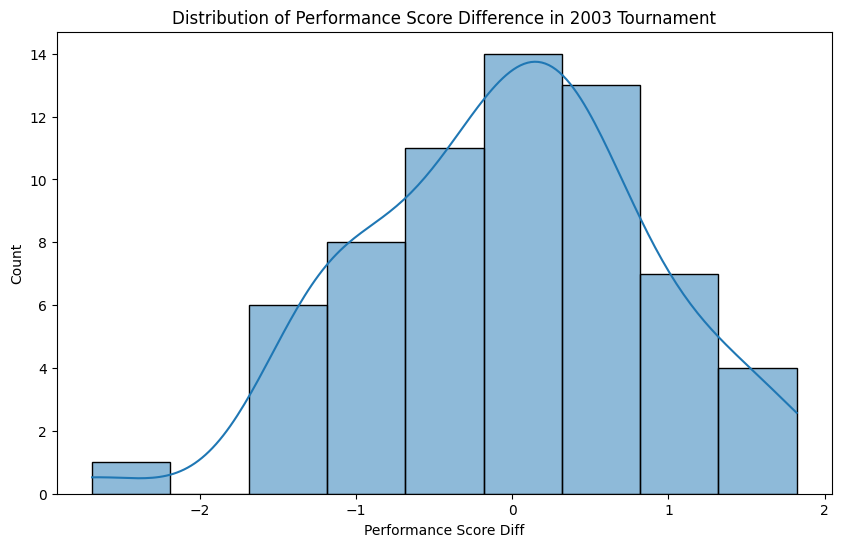

In [186]:
# let us plot the distribution of the performance difference
plt.figure(figsize=(10, 6))
plt.title('Distribution of Performance Score Difference in 2003 Tournament')
sns.histplot(df_tourney_2003['Performance Score Diff'], kde=True)
plt.show()



So it looks like its pretty even, actually is even skewered towards lower performance teams. There are two options here, adjust the weights in order to improve perfomance. Lets check how perfomance looks compare to seeding placement.

In [213]:
# create new data frame where column is the conference
# rows are the seed numbers and the cells are the performance scores
# for each team
df_seed_performance = pd.DataFrame(index=range(1, 18), columns=conferences)
# how many rows
print(df_seed_performance.shape)

# how many seeds are for each conference
for conference in conferences:
    seeds_conf = df_seeds_2003[df_seeds_2003['Seed'].str.startswith(conference)]
    print(f'{conference}: {len(seeds_conf)} seeds')

for conference in conferences:
    print(conference)
    # Filter seeds for the current conference
    seeds_conf = df_seeds_2003[df_seeds_2003['Seed'].str.startswith(conference)]
    print(seeds_conf)

    # Get performance for each team in the conference
    performance_conf = df_perfomance_score.loc[seeds_conf['TeamID'], 'Performance Score']
    print(performance_conf.values)

    # if less than the rows then pad with 0
    if len(performance_conf) < df_seed_performance.shape[0]:
        performance_conf = pd.concat([performance_conf, pd.Series([0] * (df_seed_performance.shape[0] - len(performance_conf)))])

    # Update the DataFrame
    df_seed_performance[conference] = performance_conf.values

    

df_seed_performance



(17, 4)
W: 16 seeds
X: 17 seeds
Y: 16 seeds
Z: 16 seeds
W
      Season Seed  TeamID
1154    2003  W01    1328
1155    2003  W02    1448
1156    2003  W03    1393
1157    2003  W04    1257
1158    2003  W05    1280
1159    2003  W06    1329
1160    2003  W07    1386
1161    2003  W08    1143
1162    2003  W09    1301
1163    2003  W10    1120
1164    2003  W11    1335
1165    2003  W12    1139
1166    2003  W13    1122
1167    2003  W14    1264
1168    2003  W15    1190
1169    2003  W16    1354
[ 1.23113952  1.06600793  1.36457974  0.73880767  0.63782769 -0.45695037
  0.90423223  0.31011733  0.54588002 -0.36342123  2.23487286  1.06550559
  1.8572937   1.19160411  1.64238752  1.54581902]
X
      Season  Seed  TeamID
1170    2003   X01    1400
1171    2003   X02    1196
1172    2003   X03    1462
1173    2003   X04    1390
1174    2003   X05    1163
1175    2003   X06    1268
1176    2003   X07    1277
1177    2003   X08    1261
1178    2003   X09    1345
1179    2003   X10    1160
1180 

,W,X,Y,Z
1,1.231140,1.006603,2.438500,1.505353
2,1.066008,0.602529,1.438771,1.569486
3,1.364580,1.911095,1.332853,1.128969
4,0.738808,1.174203,1.502481,1.316535
5,0.637828,0.583573,1.136103,0.198784
6,-0.456950,0.425546,0.586863,1.486332
7,0.904232,1.141468,-0.013900,1.837915
8,0.310117,0.799158,1.002255,-0.304411
9,0.545880,0.089588,1.226090,1.344032
10,-0.363421,0.654602,0.079572,0.613678


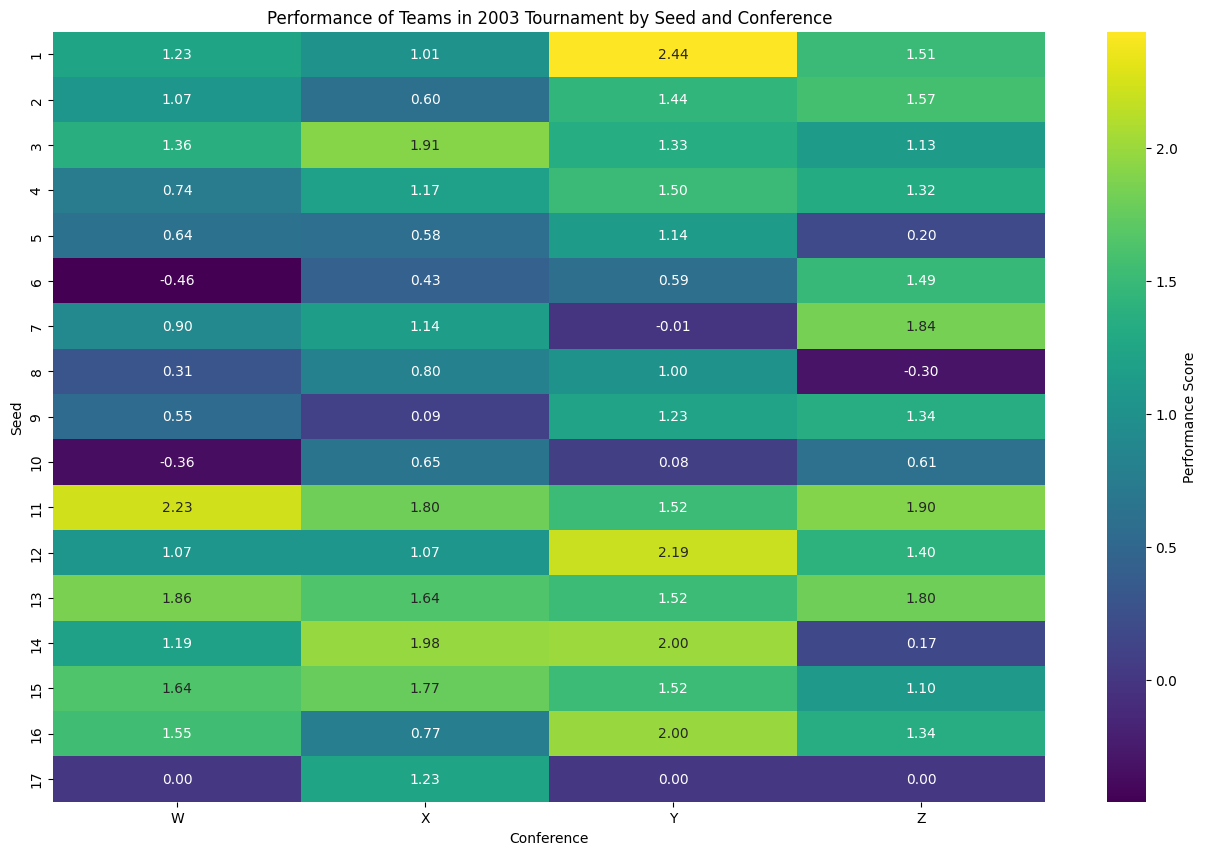

In [214]:
# lets look at this chart as a heat map
plt.figure(figsize=(16, 10))
plt.title('Performance of Teams in 2003 Tournament by Seed and Conference')
sns.heatmap(df_seed_performance, cmap='viridis', annot=True, fmt='.2f', cbar_kws={'label': 'Performance Score'})
plt.xlabel('Conference')
plt.ylabel('Seed')
plt.show()

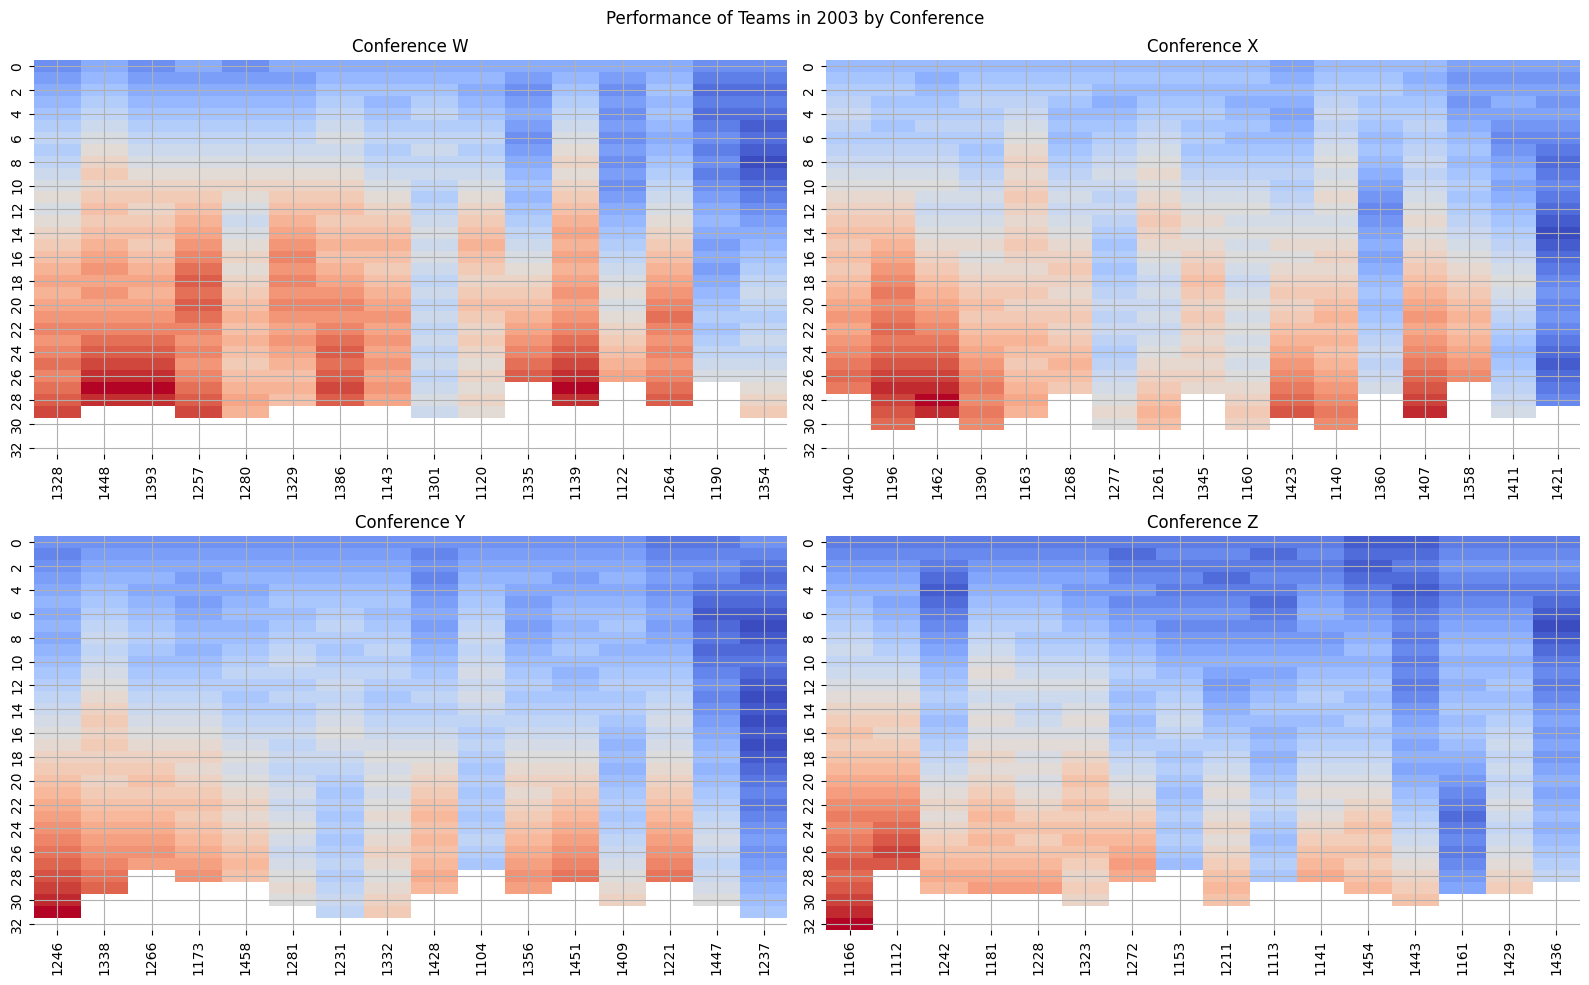

In [188]:
# for each conference lets do a heat map, with the team with the most winning games on top
# and the team with the least winning games at the bottom
# Set up the matplotlib figure
plt.figure(figsize=(16, 10))
plt.suptitle('Performance of Teams in 2003 by Conference')

# Iterate through each conference
for i, conference in enumerate(conferences):
    # Filter seeds for the current conference
    seeds_conf = df_seeds_2003[df_seeds_2003['Seed'].str.startswith(conference)]
    
    # Get performance for each team in the conference
    performance_conf = performance_df[seeds_conf['TeamID']]
    
    # Sort teams by total wins
    wins = performance_conf.iloc[-1]
    performance_conf = performance_conf[wins.sort_values(ascending=False).index]
    
    # Plot the performance
    plt.subplot(2, 2, i + 1)
    plt.title(f'Conference {conference}')
    plt.xlabel('Day')
    plt.ylabel('Performance')
    plt.grid(True)
    sns.heatmap(performance_conf, cmap='coolwarm', cbar=False)

plt.tight_layout()
plt.show()

In [7]:
# split into different conferences based on the first letter of the seed
# create a dictionary to hold the conference data frames
conference_dict = {}
# iterate through the unique conferences
for conference in df_seeds_2003['Seed'].str[0].unique():
    print(f"Conference {conference}:")
    # create a data frame for the conference based on the performance df
    df_conferences = []
    for team in df_seeds_2003[df_seeds_2003['Seed'].str[0] == conference]['TeamID']:
        # add that column to the conference data frame
        df_conferences.append(performance_df[team])
    # create a data frame from the list of columns
    df_conference = pd.DataFrame(df_conferences).transpose()
    # add the conference to the dict
    conference_dict[conference] = df_conference
    print(df_conference.head())

Conference W:
   1328  1448  1393  1257  1280  1329  1386  1143  1301  1120  1335  1139  \
0  -1.0   1.0  -1.0   1.0  -1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
1   0.0   2.0   0.0   0.0   0.0   0.0   2.0   2.0   2.0   2.0   0.0   2.0   
2   1.0   3.0   1.0   1.0   1.0   1.0   3.0   3.0   3.0   1.0  -1.0   3.0   
3   2.0   4.0   2.0   2.0   2.0   2.0   4.0   2.0   4.0   2.0   0.0   4.0   
4   3.0   5.0   3.0   3.0   3.0   3.0   5.0   3.0   5.0   3.0   1.0   5.0   

   1122  1264  1190  1354  
0   1.0   1.0  -1.0  -1.0  
1   0.0   2.0  -2.0  -2.0  
2  -1.0   3.0  -3.0  -3.0  
3   0.0   2.0  -2.0  -2.0  
4  -1.0   3.0  -3.0  -3.0  
Conference X:
   1400  1196  1462  1390  1163  1268  1277  1261  1345  1160  1423  1140  \
0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  -1.0   1.0   
1   2.0   2.0   0.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   0.0   2.0   
2   3.0   3.0   1.0   3.0   3.0   3.0   1.0   1.0   1.0   1.0   1.0   3.0   
3   4.0   2.0   2.0   4.0   4.0  

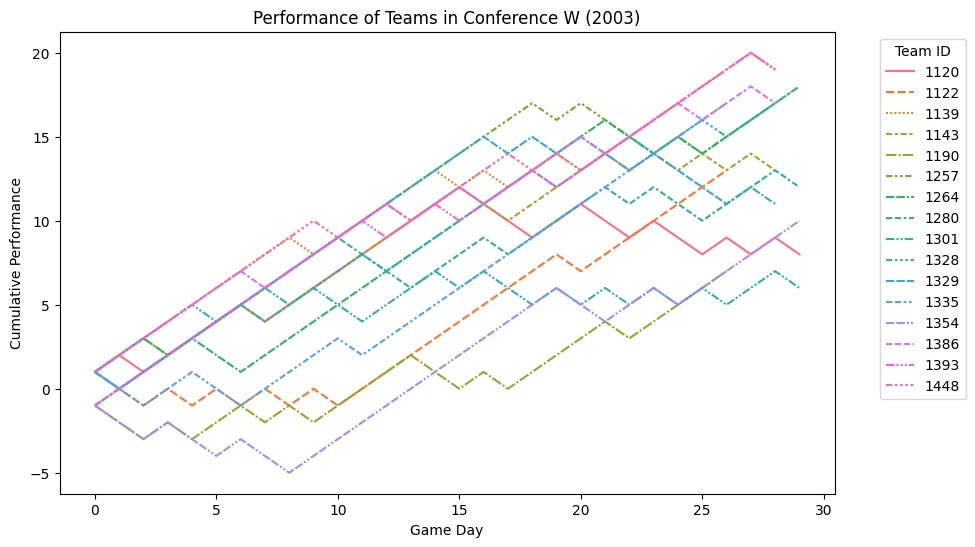

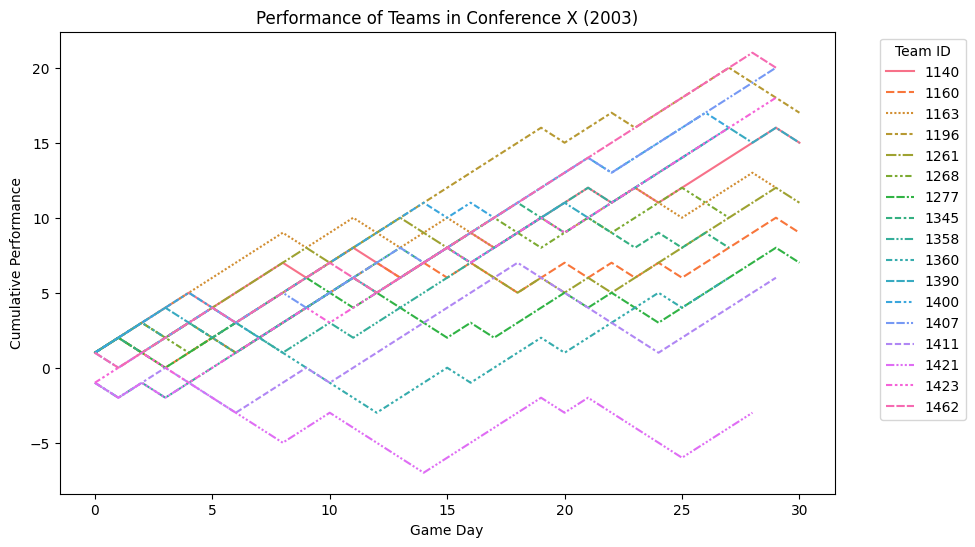

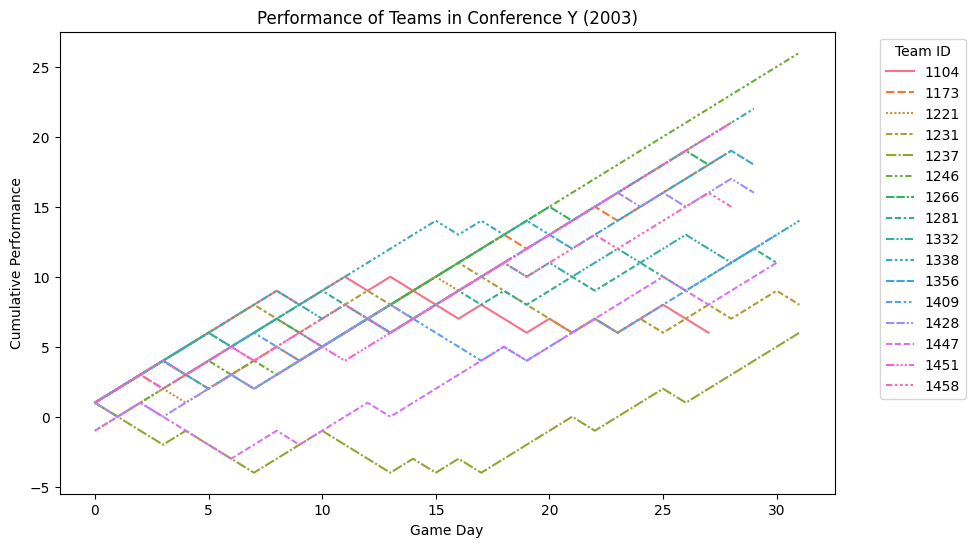

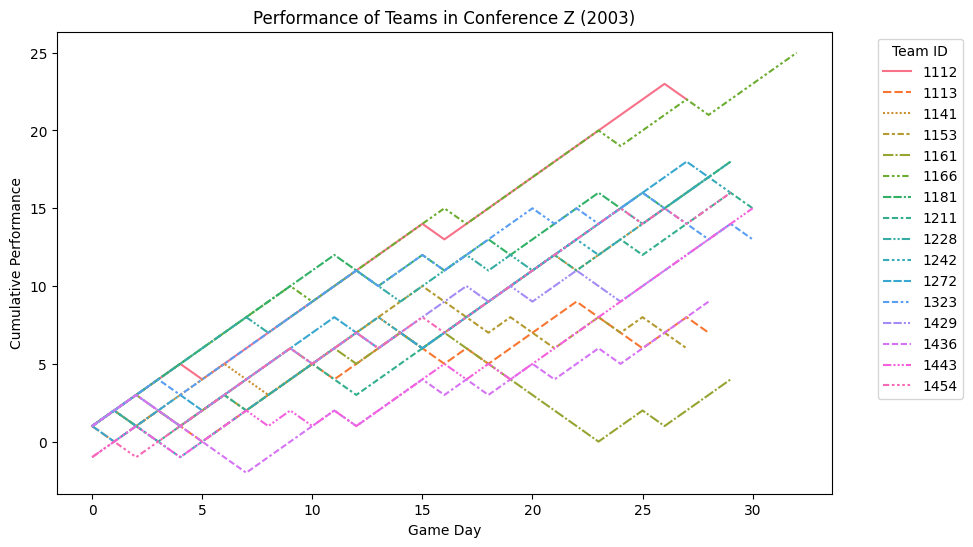

In [9]:
# plot each conference in the dict separately
import matplotlib.pyplot as plt
import seaborn as sns

for conference in conference_dict:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=conference_dict[conference])
    plt.title(f'Performance of Teams in Conference {conference} (2003)')
    plt.xlabel('Game Day')
    plt.ylabel('Cumulative Performance')
    # add legend on top left
    plt.legend(title='Team ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


In [10]:
# save to csv the performance df of the conference Y
df_conference_y = conference_dict['Y']
df_conference_y.to_csv('data/conference_y_performance.csv', index=False)

Average Slope: Represents the overall trend. Higher values indicate teams that consistently performed well.
Average Acceleration: Indicates whether a team gained or lost momentum over time.
Volatility: Measures consistency in performance. Higher values suggest more fluctuations.
Turning Points: Counts significant performance shifts, revealing teams that had major changes in momentum.

In [11]:
# Compute first derivative (slope) - rate of change in performance
df_slope = df_conference_y.diff()

# Compute second derivative (acceleration) - rate of change of the slope
df_acceleration = df_slope.diff()

# Compute volatility as the standard deviation of slopes (measure of performance consistency)
volatility = df_slope.std()

# Identify major turning points (where acceleration is significantly high)
turning_points = (df_acceleration.abs() > df_acceleration.abs().mean()).sum()

# Split the season into two halves for slope difference momentum
midpoint = len(df_conference_y) // 2
first_half_slope = df_conference_y.iloc[:midpoint].diff().mean()
second_half_slope = df_conference_y.iloc[midpoint:].diff().mean()
momentum_slope_difference = second_half_slope - first_half_slope

# Compute Exponentially Weighted Momentum (giving more weight to recent games)
weights = np.exp(np.linspace(0, 2, len(df_conference_y)))  # Exponential weights increasing over time
weighted_momentum = (df_slope.mul(weights, axis=0)).sum() / weights.sum()

# Combine all metrics into a dataframe
results_df = pd.DataFrame({
    "Average Slope": df_slope.mean(),
    "Average Acceleration": df_acceleration.mean(),
    "Volatility (Std Dev)": volatility,
    "Turning Points": turning_points,
    "Momentum (Slope Difference)": momentum_slope_difference,
    "Weighted Momentum": weighted_momentum
})

# Display the results
results_df.head()

,Average Slope,Average Acceleration,Volatility (Std Dev),Turning Points,Momentum (Slope Difference),Weighted Momentum
1246,0.806452,0.066667,0.601074,5,0.400000,0.842884
1338,0.724138,0.000000,0.701862,8,-0.174359,0.587244
1266,0.629630,-0.076923,0.791695,7,0.036364,0.419563
1173,0.642857,0.000000,0.780042,10,0.066667,0.515172
1458,0.500000,-0.074074,0.881917,11,0.033333,0.353036


In [ ]:
# convert the above to a function that takes in a conference and returns the results
def get_conference_results(df_conference):
    # Compute first derivative (slope) - rate of change in performance
    df_slope = df_conference.diff()

    # Compute second derivative (acceleration) - rate of change of the slope
    df_acceleration = df_slope.diff()

    # Compute volatility as the standard deviation of slopes (measure of performance consistency)
    volatility = df_slope.std()

    # Identify major turning points (where acceleration is significantly high)
    turning_points = (df_acceleration.abs() > df_acceleration.abs().mean()).sum()

    # Split the season into two halves for slope difference momentum
    midpoint = len(df_conference) // 2
    first_half_slope = df_conference.iloc[:midpoint].diff().mean()
    second_half_slope = df_conference.iloc[midpoint:].diff().mean()
    momentum_slope_difference = second_half_slope - first_half_slope

    # Compute Exponentially Weighted Momentum (giving more weight to recent games)
    weights = np.exp(np.linspace(0, 2, len(df_conference)))  # Exponential weights increasing over time
    weighted_momentum = (df_slope.mul(weights, axis=0)).sum() / weights.sum()

    # Combine all metrics into a dataframe
    results_df = pd.DataFrame({
        "Average Slope": df_slope.mean(),
        "Average Acceleration": df_acceleration.mean(),
        "Volatility (Std Dev)": volatility,
        "Turning Points": turning_points,
        "Momentum (Slope Difference)": momentum_slope_difference,
        "Weighted Momentum": weighted_momentum
    })
    
    return results_df

In [137]:
import numpy as np
import pandas as pd

def team_performance_score(df, w1=1, w2=1, w3=1, w4=1, w5=1, w6=1):
    """
    Computes a weighted performance score for each team.
    
    Parameters:
    df : DataFrame containing performance metrics for each team.
    w1, w2, w3, w4, w5, w6 : Weights for different metrics (default = 1).
    
    Returns:
    DataFrame with scores for each team.
    """
    # Compute inverse for volatility and turning points to give higher scores for more stable teams
    inv_volatility = 1 / (df["Volatility (Std Dev)"] + 1e-6)  # Add small value to avoid division by zero
    inv_turning_points = 1 / (df["Turning Points"] + 1e-6)

    # Compute the score
    df["Performance Score"] = (
        w1 * df["Average Slope"] +
        w2 * df["Average Acceleration"] +
        w3 * inv_volatility +
        w4 * inv_turning_points +
        w5 * df["Momentum (Slope Difference)"] +
        w6 * df["Weighted Momentum"]
    )

    return df[["Performance Score"]]

# Example Usage:
results_df = team_performance_score(results_df)


KeyError: 'Volatility (Std Dev)'

In [13]:
results_df

,Performance Score
1246,3.979687
1338,2.686801
1266,2.414602
1173,2.606676
1458,2.037097
1281,1.258675
1231,0.544314
1332,1.792431
1428,2.203691
1104,0.627102


In [14]:
# what were the seeds on this conference Y in 2003
df_seeds_2003[df_seeds_2003['Seed'].str[0] == 'Y']


,Season,Seed,TeamID
1187,2003,Y01,1246
1188,2003,Y02,1338
1189,2003,Y03,1266
1190,2003,Y04,1173
1191,2003,Y05,1458
1192,2003,Y06,1281
1193,2003,Y07,1231
1194,2003,Y08,1332
1195,2003,Y09,1428
1196,2003,Y10,1104


In [15]:
#merge the seeds with the performance score by team and sort by the performance score
df_seeds_performance = pd.merge(df_seeds_2003, results_df, left_on='TeamID', right_index=True)
df_seeds_performance = df_seeds_performance.sort_values(by='Performance Score', ascending=False)
df_seeds_performance

,Season,Seed,TeamID,Performance Score
1187,2003,Y01,1246,3.979687
1200,2003,Y14,1221,3.439391
1198,2003,Y12,1451,3.430369
1188,2003,Y02,1338,2.686801
1202,2003,Y16,1237,2.618597
1190,2003,Y04,1173,2.606676
1197,2003,Y11,1356,2.552981
1189,2003,Y03,1266,2.414602
1201,2003,Y15,1447,2.366473
1199,2003,Y13,1409,2.225643


In [16]:
# what are the teams seeded:
teams_2003_Y = df_seeds_performance['TeamID'].unique()
teams_2003_Y

array([1246, 1221, 1451, 1338, 1237, 1173, 1356, 1266, 1447, 1409, 1428,
       1458, 1332, 1281, 1104, 1231])

# Tournament
Now lets find out how these score relate to how they performed on the tournament.
Lets build a tree that shows the tournament progression and the performance score of each team.

In [111]:
# load the tournament detailed results.
df_tourney = pd.read_csv('data/MNCAATourneyDetailedResults.csv')
# filter to only 2003 and contains the team ids that were seeded for the conference

df_tourney_2003 = df_tourney[df_tourney['Season'] == 2003]
df_tourney_2003.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


In [112]:
# now lets clip how the tournament went for the teams in the conference Y
df_tourney_2003_Y = df_tourney_2003[df_tourney_2003['WTeamID'].isin(teams_2003_Y) | df_tourney_2003['LTeamID'].isin(teams_2003_Y)]
df_tourney_2003_Y

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
10,2003,136,1266,72,1221,68,N,0,22,51,...,15,15,25,14,20,14,9,4,1,20
11,2003,136,1281,72,1356,71,N,0,28,52,...,19,11,21,11,18,19,13,6,0,19
15,2003,136,1409,84,1173,71,N,0,33,57,...,28,6,9,12,16,11,11,3,3,19
16,2003,136,1458,81,1451,74,N,0,31,58,...,24,9,15,22,21,9,10,4,0,20
20,2003,137,1231,67,1104,62,N,0,19,49,...,12,13,16,9,20,13,8,2,6,21
21,2003,137,1246,95,1237,64,N,0,40,65,...,15,16,22,15,18,10,19,7,1,15
26,2003,137,1338,87,1447,61,N,0,33,59,...,21,12,18,9,20,13,19,6,2,20
30,2003,137,1428,60,1332,58,N,0,18,61,...,17,17,24,13,29,8,17,6,2,22
37,2003,138,1266,101,1281,92,N,1,35,62,...,36,15,19,18,20,19,12,4,4,17
40,2003,138,1458,61,1409,60,N,0,22,57,...,11,5,5,11,30,12,11,1,3,16


In [121]:
# lets create difference columns for each of the tracking statistics
# for each W column and subtract the corresponding L column
for col in df_tourney_2003_Y.columns:
    # skip teams and loc
    if col in ['Season', 'DayNum', 'WTeamID', 'LTeamID', 'WLoc']:
        continue
    # if the column starts with W then subtract the corresponding L column
    # and create a new column with the initial D
    if col.startswith('W'):
        new_col = col.replace('W', 'D')
        df_tourney_2003_Y.loc[:,new_col] = df_tourney_2003_Y.loc[:,col] - df_tourney_2003_Y.loc[:,col.replace('W', 'L')]
        # drop the W and L columns
        df_tourney_2003_Y = df_tourney_2003_Y.drop(columns=[col, col.replace('W', 'L')])
df_tourney_2003_Y

/tmp/ipykernel_362834/2087307433.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tourney_2003_Y.loc[:,new_col] = df_tourney_2003_Y.loc[:,col] - df_tourney_2003_Y.loc[:,col.replace('W', 'L')]


,Season,DayNum,WTeamID,LTeamID,WLoc,NumOT,DScore,DFGM,DFGA,DFGM3,DFGA3,DFTM,DFTA,DOR,DDR,DAst,DTO,DStl,DBlk,DPF
10,2003,136,1266,1221,N,0,4,-2,-3,4,1,4,-2,-3,0,0,1,0,2,3
11,2003,136,1281,1356,N,0,1,2,-13,-3,-6,0,-3,-2,14,-12,10,-2,6,0
15,2003,136,1409,1173,N,0,13,5,-9,-1,-16,4,4,-4,10,7,1,3,-2,-8
16,2003,136,1458,1451,N,0,7,2,-13,-1,-8,4,7,-12,3,7,-1,3,2,-4
20,2003,137,1231,1104,N,0,5,-3,-3,2,6,9,10,4,2,2,0,-1,-4,-4
21,2003,137,1246,1237,N,0,31,18,5,6,5,-11,-11,-5,7,12,-6,0,3,2
26,2003,137,1338,1447,N,0,26,12,8,2,-5,0,3,1,3,9,-10,8,4,-1
30,2003,137,1428,1332,N,0,2,-1,6,6,6,-2,-6,0,-6,0,-2,1,2,0
37,2003,138,1266,1281,N,1,9,4,-10,-3,-18,4,1,-10,5,-1,0,2,-4,3
40,2003,138,1458,1409,N,0,1,-4,-2,3,11,6,12,-1,-8,0,-6,4,0,-5


In [114]:
# lets create another dataset that contains only the teams that were seeded in the conference Y
df_tourney_2003_Y = df_tourney_2003[(df_tourney_2003['WTeamID'].isin(teams_2003_Y)) & (df_tourney_2003['LTeamID'].isin(teams_2003_Y))]
df_tourney_2003_Y.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
10,2003,136,1266,72,1221,68,N,0,22,51,...,15,15,25,14,20,14,9,4,1,20
11,2003,136,1281,72,1356,71,N,0,28,52,...,19,11,21,11,18,19,13,6,0,19
15,2003,136,1409,84,1173,71,N,0,33,57,...,28,6,9,12,16,11,11,3,3,19
16,2003,136,1458,81,1451,74,N,0,31,58,...,24,9,15,22,21,9,10,4,0,20
20,2003,137,1231,67,1104,62,N,0,19,49,...,12,13,16,9,20,13,8,2,6,21


In [115]:
# game 1
game1 = df_tourney_2003_Y.iloc[0]
game1

Season     2003
DayNum      136
WTeamID    1266
WScore       72
LTeamID    1221
LScore       68
WLoc          N
NumOT         0
WFGM         22
WFGA         51
WFGM3         9
WFGA3        16
WFTM         19
WFTA         23
WOR          11
WDR          20
WAst         14
WTO          10
WStl          4
WBlk          3
WPF          23
LFGM         24
LFGA         54
LFGM3         5
LFGA3        15
LFTM         15
LFTA         25
LOR          14
LDR          20
LAst         14
LTO           9
LStl          4
LBlk          1
LPF          20
Name: 10, dtype: object

In [116]:
# what was the performance score of each team in the game previously
team1 = game1['WTeamID']
print(team1)
team1_score = df_seeds_performance[df_seeds_performance['TeamID'] == team1]['Performance Score'].values[0]
team1_seed = df_seeds_performance[df_seeds_performance['TeamID'] == team1]['Seed'].values[0]
print(team1_seed)
print(team1_score)
team2 = game1['LTeamID']
print(team2)
team2_seed = df_seeds_performance[df_seeds_performance['TeamID'] == team2]['Seed'].values[0]
print(team2_seed)
team2_score = df_seeds_performance[df_seeds_performance['TeamID'] == team2]['Performance Score'].values[0]
print(team2_score)
# difference
print(team1_score - team2_score)

1266
Y03
2.4146021100170594
1221
Y14
3.4393913235670115
-1.0247892135499521


In [117]:
# now lets calculate the ratios of each game and differenes


In [118]:
# lets create a team object
class team:
    def __init__(self, id, seed, regular_performance, conference):
        self.id = id
        self.seed = seed
        self.regular_performance = regular_performance
        self.conference
        self.running_performance = 0
        self.running_performance_list = []
    
    def __str__(self):
        return f"Team {self.id} Seed {self.seed} Regular Performance {self.regular_performance} Conference {self.conference}"

In [119]:
# lets create a node for a game
class game_node:
    def __init__(self, team1, team2, row_data):
        self.team1 = team1
        self.team2 = team2
        self.loser = row_data['LTeamID']
        self.winner = row_data['WTeamID']
        self.wteam = team1 if self.winner == team1.id else team2
        self.lteam = team1 if self.loser == team1.id else team2
    
    # lets parse through row data to get match statistics
    def parse_row_data(self, row_data):
        self.winner_score = row_data['WScore']
        self.loser_score = row_data['LScore']
        self.winner_seed = self.wteam.seed
        self.loser_seed = self.lteam.seed
        self.wloc = row_data['WLoc'] # winning team location
        self.num_ot = row_data['NumOT'] # number of over time periods

        # winning team statistics
        self.wfg_ratio = row_data['WFGM'] / row_data['WFGA'] # field goal ratio
        self.wfg3_ratio = row_data['WFGM3'] / row_data['WFGA3'] # field goal 3 ratio
        self.wft_ratio = row_data['WFTM'] / row_data['WFTA'] # free throw ratio
        self.wor = row_data['WOR'] # offensive rebounds
        self.wdr = row_data['WDR'] # defensive rebounds
        self.wast = row_data['WAst'] # assists
        self.wto = row_data['WTO'] # turnovers
        self.wstl = row_data['WStl'] # steals
        self.wblk = row_data['WBlk'] # blocks
        self.wpf = row_data['WPF'] # personal fouls

        # losing team statistics
        self.lfg_ratio = row_data['LFGM'] / row_data['LFGA']
        self.lfg3_ratio = row_data['LFGM3'] / row_data['LFGA3']
        self.lft_ratio = row_data['LFTM'] / row_data['LFTA']
        self.lor = row_data['LOR']
        self.ldr = row_data['LDR']
        self.last = row_data['LAst']
        self.lto = row_data['LTO']
        self.lstl = row_data['LStl']
        self.lblk = row_data['LBlk']
        self.lpf = row_data['LPF']

        # calculate the difference between the two teams
    def get_diff_statistics(self):
        self.fg_ratio_diff = self.wfg_ratio - self.lfg_ratio
        self.fg3_ratio_diff = self.wfg3_ratio - self.lfg3_ratio
        self.ft_ratio_diff = self.wft_ratio - self.lft_ratio
        self.or_diff = self.wor - self.lor
        self.dr_diff = self.wdr - self.ldr
        self.ast_diff = self.wast - self.last
        self.to_diff = self.wto - self.lto
        self.stl_diff = self.wstl - self.lstl
        self.blk_diff = self.wblk - self.lblk
        self.pf_diff = self.wpf - self.lpf
        
    def print_stats(self):
        print("""
            Game Stats:\n
            ==========
            Winner : {self.winner}\tLoser : {self.loser}
            Winner Score : {self.winner_score}\tLoser Score : {self.loser_score} \n
            Winner Seed : {self.winner_seed}\tLoser Seed : {self.loser_seed} \n
            Winner Location : {self.wloc}\tNumber of OT : {self.num_ot} \n
            Winner FG Ratio : {self.wfg_ratio}\tLoser FG Ratio : {self.lfg_ratio} \tFG Ratio Diff : {self.fg_ratio_diff} \n
            Winner FG3 Ratio : {self.wfg3_ratio}\tLoser FG3 Ratio : {self.lfg3_ratio} \tFG3 Ratio Diff : {self.fg3_ratio_diff} \n
            Winner FT Ratio : {self.wft_ratio}\tLoser FT Ratio : {self.lft_ratio} \tFT Ratio Diff : {self.ft_ratio_diff} \n
            Winner OR : {self.wor}\tLoser OR : {self.lor} \tOR Diff : {self.or_diff} \n
            Winner DR : {self.wdr}\tLoser DR : {self.ldr} \tDR Diff : {self.dr_diff} \n
            Winner AST : {self.wast}\tLoser AST : {self.last} \tAST Diff : {self.ast_diff} \n
            Winner TO : {self.wto}\tLoser TO : {self.lto} \tTO Diff : {self.to_diff} \n
            Winner STL : {self.wstl}\tLoser STL : {self.lstl} \tSTL Diff : {self.stl_diff} \n
            Winner BLK : {self.wblk}\tLoser BLK : {self.lblk} \tBLK Diff : {self.blk_diff} \n
            Winner PF : {self.wpf}\tLoser PF : {self.lpf} \tPF Diff : {self.pf_diff} \n
              """)


        
    

        

In [120]:
# lets match each team and find out the performance of the each team

